<a href="https://colab.research.google.com/github/SergeiVKalinin/ACerS_AE_2024/blob/main/22_Orchestrated_exp_1_modality_LVAE_2d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Singe modality orchestrated experiment with LVAE

@prepared Boris Slautin

@supervision Sergei Kalinin

@data Richard Liu

03/26/2024

In [1]:
!pip install --upgrade git+https://github.com/ziatdinovmax/pyroved.git
!pip install git+https://github.com/ziatdinovmax/gpax@main

!pip install mycolorpy

!pip install igor2

  Cloning https://github.com/ziatdinovmax/pyroved.git to /tmp/pip-req-build-c6iu96v5
  Running command git clone --filter=blob:none --quiet https://github.com/ziatdinovmax/pyroved.git /tmp/pip-req-build-c6iu96v5
  Resolved https://github.com/ziatdinovmax/pyroved.git to commit 7807ffb1cb415b3cc76c1e02d52465a8ae0eeae4
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.2/745.2 kB 7.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import h5py

import torch
import pyroved as pv

from IPython.core.display import Video
import imageio

import gpax
import numpyro
gpax.utils.enable_x64()

from google.colab import drive

import numpyro.distributions as dist
import jax.numpy as jnp

import os
from igor2 import binarywave as bw

In [3]:
def normalize(data):
  return [np.min(data),np.ptp(data)], (data - np.min(data))/(np.ptp(data))

In [4]:
# @title IBWData
class IBWData:
    def __init__(self, header=None, channels=None, data=None, size=None):
        self.header = header if header is not None else {}
        self.channels = channels if channels is not None else []
        self.data = data if data is not None else []

    def __repr__(self):
        return f"IBWData(header={self.header}, channels={self.channels}, data={self.data})"

def load_ibw(file, ss=False):
    '''
    Load the ibw file into an IBWData object.
    It automatically creates three default attributes:
      1. header: a dict contains all the setup information
      2. channels: a list of channel names for each image data
      3. data: an array of all the saved image data in this ibw file
    '''
    t = bw.load(file)
    wave = t.get('wave')

    # Decode the notes section to parse the header
    if isinstance(wave['note'], bytes):
        try:
            parsed_string = wave['note'].decode('utf-8').split('\r')
        except:
            parsed_string = wave['note'].decode('ISO-8859-1').split('\r')
    header = {}
    for item in parsed_string:
        try:
            key, value = item.split(':', 1)
            value = value.strip()  # Remove leading/trailing whitespace
        except ValueError:
            continue  # For items that do not split correctly

        # Determine the data type of the value and convert
        if '.' in value or 'e' in value:  # Floating point check
            try:
                header[key] = float(value)
            except ValueError:
                header[key] = value
        elif value.lstrip('-').isdigit():  # Integer check
            header[key] = int(value)
        else:
            header[key] = value

    # Transpose the data matrix
    data = wave['wData'].T
    # data = wave['wData']

    # Extract channel data types from the header
    channels = [header.get(f'Channel{i+1}DataType', 'Unknown') for i in range(np.shape(data)[0])]
    out = IBWData(header, channels, data)
    out.size = header['ScanSize']
    out.mode = header['ImagingMode']
    if out.mode == "PFM Mode":
        if len(out.channels) > 4:
            out.mode = "DART Mode"
            out.channels = ['Height', 'Amplitude1', 'Amplitude2', 'Phase1', 'Phase2', 'Frequency']
        else:
            out.channels = ['Height', 'Amplitude', 'Deflection', 'Phase']

    # Load the switching spectroscopy (hysteresis loop) data
    if ss is not False:
        bias_raw= data[-1]
        index_values = np.where(~np.isnan(bias_raw))

        bias = bias_raw[index_values]
        amp, phase1, phase2 = data[2][index_values], data[3][index_values], data[4][index_values]
        index_bp = np.where(np.diff(bias) != 0)[0] + 1
        index_bp = np.concatenate([[0], index_bp])

        length = len(index_bp) // 2

        bias_on = np.zeros(length)

        phase1_on = np.zeros(length)
        phase1_off = np.zeros(length)

        phase2_on = np.zeros(length)
        phase2_off = np.zeros(length)

        amp_on = np.zeros(length)
        amp_off = np.zeros(length)

        for i in range(length * 2-1):
            if i % 2 == 0: # bias off
                phase1_off[i//2] = np.mean(phase1[index_bp[i]:index_bp[i+1]])
                phase2_off[i//2] = np.mean(phase2[index_bp[i]:index_bp[i+1]])
                amp_off[i//2] = np.mean(amp[index_bp[i]:index_bp[i+1]])
            else:
                bias_on[i//2] = np.mean(bias[index_bp[i]:index_bp[i+1]])
                phase1_on[i//2] = np.mean(phase1[index_bp[i]:index_bp[i+1]])
                phase2_on[i//2] = np.mean(phase2[index_bp[i]:index_bp[i+1]])
                amp_on[i//2] = np.mean(amp[index_bp[i]:index_bp[i+1]])
        out.bias = bias_on
        out.phase1_on = phase1_on
        out.phase1_off = phase1_off
        out.phase2_on = phase2_on
        out.phase2_off = phase2_off
        out.amp_on = amp_on * np.cos(phase1_off/180*np.pi)
        out.amp_off = amp_off * np.cos(phase1_off/180*np.pi)
        out.data = data
    # Return an IBWData object
    return out


In [5]:
#@title Function to read and plot all the ibw files

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def display_ibw_folder(folder, mode=None, key=['Height'], paras=None, save=None):
    '''
    Display all the ibw with specified modes in a given folder.

    Input:
        folder  - Required: path to the folder to be explored
        mode    - Optional: if not given, all available modes will be displayed
                            can be 'AC Mode', 'PFM Mode', 'Contact Mode',
                            To be added: 'DART Mode', 'SKPM Mode'
        key     - Optional: list of channels to be displayed
        paras   - Optional: to be added for visualizing parameters

    Output:
        ibw_files   -list: ibw file names in the same order as they are displayed
        data        -list: SciFiReader object of each ibw file displayed

    Example use:
        ibw_files, data = display_ibw(folder, mode='AC Mode', key=['Height', 'ZSensor'], paras=None)
    '''
    file_names = os.listdir(folder)
    file_names = sorted(file_names)

    file_displayed = []
    out = []

    # if key != None:
    #   if not isinstance(key, list):
    #       key = list(key)

    # n_cols = len(key)
    # chennel_dict = {
    #     'AC Mode':      ['Height', 'Amplitude', 'Phase', 'ZSensor'],
    #     'PFM Mode':     ['Height', 'Amplitude', 'Phase', 'Deflection'],
    #     'DART Mode':    ['Height', 'Amplitude1', 'Phase1', 'Frequency', 'Amplitude2', 'Phase2'],
    #     'Contact Mode': ['Height', 'Amplitude', 'Phase', 'Deflection'],
    # }

    display_index = 0
    for index, file in enumerate(file_names):
        if file.endswith('.ibw'):
            fname = os.path.join(folder, file)
            try:
                t = load_ibw(fname)
            except TypeError:
                pass
            if len(t.data.shape) == 3: # skip the spectrum ibw files
                if mode == None:
                    display_ibw(t, key=key, display_index=display_index, save=save)
                    file_displayed.append(fname)
                    out.append(t)
                    display_index += 1
                elif mode == t.mode:
                    display_ibw(t, key=key, display_index=display_index, save=save)
                    file_displayed.append(fname)
                    out.append(t)
                    display_index += 1
            else:
                pass

    return file_displayed, out

def display_ibw(file, key=None, titles=None, save=None, display_index=None):
    '''
    Display a single ibw  file with specified channel to display.

    Input:
        file    - Required: path to the file to be displayed
        key     - Optional: list of channels to be displayed
        titles  - Optional: list of titles to overrid the channel names in the plot
        save    - Optional: controls whether the image will be saved. Default: None.
                          if provided, the image displayed will be saved as "save.png"

    Output:
        data    - IBWData object: object contains all the information in the ibw file

    Example use:
        data = display_ibw(file, key=['Height', 'ZSensor'], save="SaveName")
    '''
    try:
        if type(file) is str:
            t = load_ibw(file)
        else:
            t = file

#         if titles is not None:
#             if type(titles) is not list:
#                 titles = list(titles)

        if len(t.data.shape) == 3: # skip the spectrum ibw files
            indices = find_channel(obj=t, key=key)
            if len(indices) == 1: # Only one channel will be displayed
                plt.figure(figsize=[4,4])
                to_plot = t.data[indices[0]]
                im = plt.imshow(to_plot, extent=[0, t.size*1e6, 0, t.size*1e6])
                title = "{}: {}-{}".format(display_index, t.mode, key[0]) if not titles else titles
                plt.title(title)
                divider = make_axes_locatable(plt.gca())
                cax = divider.append_axes("right", size="5%", pad=0.05)
                plt.colorbar(im, cax=cax)
                plt.tight_layout()
                if save is not None:
                    plt.savefig('{}.png'.format(save), dpi=400, bbox_inches='tight', pad_inches=0.1)
            else:
                n_cols = len(indices)
                fig,ax=plt.subplots(1, n_cols, figsize=[n_cols*3+1, 3])
                for i in range(len(indices)):
                    to_plot = t.data[indices[i]]
                    im = ax[i].imshow(to_plot, extent=[0, t.size*1e6, 0, t.size*1e6])
                    # fig.colorbar(im, ax=ax[i])
                    divider = make_axes_locatable(ax[i])
                    cax = divider.append_axes("right", size="5%", pad=0.05)
                    fig.colorbar(im, cax=cax)
                    if titles is None:
                        if not i:
                            ax[i].set_title("{}: {}-{}".format(display_index, t.mode, t.channels[indices[i]]))
                        else:
                            ax[i].set_title("{}".format(t.channels[indices[i]]))
                    else:
                        ax[i].set_title(titles[i])
                    plt.tight_layout()
                    if save is not None:
                        plt.savefig('{}.png'.format(save), dpi=400, bbox_inches='tight', pad_inches=0.1)
        else:
            pass
    except TypeError:
        pass

# Help function to find the index of corresponding channel key
def find_channel(obj, key):
    if key is None:
        return np.arange(len(obj.channels))
    else:
        index = []
        channels = obj.channels

        for item in key:
            if item in channels:
                index.append(channels.index(item))
        return index

In [6]:
#@title Linear VAE class

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy
import tensorflow.keras as keras
from keras import layers



class CustomVAE(Model):
    def __init__(self, encoder, decoder, image_size, **kwargs):
        super(CustomVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        if type(image_size) is int:
          self.image_size = image_size
        elif type(image_size) is tuple:
          self.image_size = image_size[0]*image_size[1]

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        return reconstructed

    def train_step(self, data):
        if isinstance(data, tuple):
            x, y = data
        else:
            x = data
            y = None

        # Check if labels are provided
        if y is None:
            raise ValueError("Digit labels are required for custom training.")


        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x)
            reconstructed = self.decoder(z)

            # Reconstruction loss
            reconstruction_loss = binary_crossentropy(K.flatten(x), K.flatten(reconstructed))
            reconstruction_loss *= self.image_size

            # KL divergence
            kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
            kl_loss = -0.5*K.sum(kl_loss, axis=-1)

            # Custom loss
            batch_size = tf.shape(x)[0]
            y_true = tf.cast(y[:batch_size], dtype='float32')
            custom_loss = K.mean(K.square(z[:,0] - y_true), axis=-1)*10

            # Total loss
            total_loss = K.mean(reconstruction_loss + kl_loss + custom_loss)

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {'loss': total_loss, 'reconstruction_loss': reconstruction_loss, 'kl_loss': kl_loss, 'custom_loss': custom_loss}

    def plot_latent_space(self, n=30, figsize=15):
      # Display a grid of n*n digits (default 30*30)
      grid_x = np.linspace(-4, 4, n)
      grid_y = np.linspace(-4, 4, n)

      fig, ax = plt.subplots(n,n,figsize=(figsize, figsize), constrained_layout=True)
      for i, yi in enumerate(grid_y):
          for j, xi in enumerate(grid_x):
              z_sample = np.array([[xi, yi]])
              x_decoded = self.decoder.predict(z_sample, verbose=0)
              digit = x_decoded[0]
              ax[i,j].plot(digit)
              ax[i,j].set_xticks([])  # Hide x-axis ticks
              ax[i,j].set_yticks([])  # Hide y-axis ticks

      plt.show()

    def plot_2Dlatent_space(vae, n=30, figsize=15):
      # Display a grid of n*n digits (default 30*30)
      grid_x = np.linspace(-4, 4, n)
      grid_y = np.linspace(-4, 4, n)

      fig, ax = plt.subplots(n,n,figsize=(figsize, figsize), constrained_layout=True)
      for i, yi in enumerate(grid_y):
          for j, xi in enumerate(grid_x):
              z_sample = np.array([[xi, yi]])
              x_decoded = vae.decoder.predict(z_sample, verbose=0)
              digit = x_decoded[0]
              ax[i,j].imshow(digit)
              ax[i,j].set_xticks([])  # Hide x-axis ticks
              ax[i,j].set_yticks([])  # Hide y-axis ticks

      plt.show()


class Encoder:
  def __init__(self, input_shape, latent_dim=2, intermediate_dim=None):
    self.in_sh = input_shape
    self.latent_dim = latent_dim
    self.intermediate_dim = intermediate_dim

    if type(input_shape) is int:
      self.encoder = self.set_1D_encoder()
    elif (type(input_shape) is tuple) and (len(input_shape) == 2):#2D case
      self.encoder = self.set_2D_encoder()


  def set_1D_encoder(self, input_shape = None, latent_dim=None, intermediate_dim=128):
    if input_shape is None:
      input_shape = self.in_sh
    if latent_dim is None:
      latent_dim = self.latent_dim
    if self.intermediate_dim is not None:
      intermediate_dim = self.intermediate_dim

    encoder_inputs = keras.Input(shape=(input_shape,))
    x = layers.Dense(intermediate_dim, activation="relu")(encoder_inputs)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

    z = layers.Lambda(self.sampling)([z_mean, z_log_var])
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

    return encoder

  def set_2D_encoder(self, input_shape = None, latent_dim=None, intermediate_dim=[64,128,256]):
    if input_shape is None:
      input_shape = self.in_sh
    if latent_dim is None:
      latent_dim = self.latent_dim
    if self.intermediate_dim is not None:
      intermediate_dim = self.intermediate_dim

    encoder_inputs = keras.Input(shape=(input_shape[0], input_shape[1], 1))
    x = layers.Conv2D(intermediate_dim[0], 3, activation='relu', strides=2, padding='same')(encoder_inputs)
    x = layers.Conv2D(intermediate_dim[1], 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(intermediate_dim[2], activation='relu')(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)

    z = layers.Lambda(self.sampling)([z_mean, z_log_var])
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    return encoder

  @staticmethod
  def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


class Decoder:
  def __init__(self, output_shape, latent_dim=2, intermediate_dim=None):
    self.output_shape = output_shape
    self.latent_dim = latent_dim
    self.intermediate_dim = intermediate_dim

    #1D case
    if type(output_shape) is int:
      self.decoder = self.set_1D_decoder()
    #2D case
    elif (type(output_shape) is tuple) and (len(output_shape) == 2):
      self.decoder = self.set_2D_decoder()

  def set_1D_decoder(self, output_shape = None, latent_dim=None, intermediate_dim=128):
    if output_shape is None:
      output_shape = self.output_shape
    if latent_dim is None:
      latent_dim = self.latent_dim
    if self.intermediate_dim is not None:
      intermediate_dim = self.intermediate_dim

    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(intermediate_dim, activation="relu")(latent_inputs)
    decoder_outputs = layers.Dense(output_shape, activation='sigmoid')(x)
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

    return decoder

  def set_2D_decoder(self, output_shape = None, latent_dim=None, intermediate_dim=[64,128,256]):
    if output_shape is None:
      output_shape = self.output_shape
    if latent_dim is None:
      latent_dim = self.latent_dim
    if self.intermediate_dim is not None:
      intermediate_dim = self.intermediate_dim

    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(intermediate_dim[-1], activation='relu')(latent_inputs)
    x = layers.Dense(output_shape[0]//4 * output_shape[1]//4 * intermediate_dim[-2], activation='relu')(x)
    x = layers.Reshape((output_shape[0]//4, output_shape[1]//4, intermediate_dim[-2]))(x)
    x = layers.Conv2DTranspose(intermediate_dim[-2], 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Conv2DTranspose(intermediate_dim[-3], 3, activation='relu', strides=2, padding='same')(x)
    decoder_outputs = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)

    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
    return decoder

## Import IBW data

In [7]:
!gdown https://drive.google.com/file/d/1lAAPdFs8wveGkx59dIwG_YYofEGvsyTE/view?usp=drive_link --fuzzy

Downloading...
From (original): https://drive.google.com/uc?id=1lAAPdFs8wveGkx59dIwG_YYofEGvsyTE
From (redirected): https://drive.google.com/uc?id=1lAAPdFs8wveGkx59dIwG_YYofEGvsyTE&confirm=t&uuid=97c12089-4549-42af-bb19-cdc68f269fae
To: /content/WTV_AG.zip
100% 48.1M/48.1M [00:01<00:00, 41.8MB/s]


In [8]:
!unzip /content/WTV_AG.zip

Archive:  /content/WTV_AG.zip
 extracting: WTV_AG/WTV_AG_test_0000.ibw  
 extracting: WTV_AG/WTV_AG_test_0001.ibw  
 extracting: WTV_AG/WTV_Loc001_0000.ibw  
 extracting: WTV_AG/WTV_Loc001_0001.ibw  
 extracting: WTV_AG/WTV_Loc002_0000.ibw  
 extracting: WTV_AG/WTV_Loc002_0001.ibw  
 extracting: WTV_AG/WTV_Loc003_0000.ibw  
 extracting: WTV_AG/WTV_Loc003_0001.ibw  
 extracting: WTV_AG/WTV_Loc004_0000.ibw  
 extracting: WTV_AG/WTV_Loc004_0001.ibw  
 extracting: WTV_AG/WTV_Loc005_0000.ibw  
 extracting: WTV_AG/WTV_Loc005_0001.ibw  
 extracting: WTV_AG/WTV_Loc006_0000.ibw  
 extracting: WTV_AG/WTV_Loc006_0001.ibw  
 extracting: WTV_AG/WTV_Loc007_0000.ibw  
 extracting: WTV_AG/WTV_Loc007_0001.ibw  
 extracting: WTV_AG/WTV_Loc008_0000.ibw  
 extracting: WTV_AG/WTV_Loc008_0001.ibw  
 extracting: WTV_AG/WTV_Loc009_0000.ibw  
 extracting: WTV_AG/WTV_Loc009_0001.ibw  
 extracting: WTV_AG/WTV_Loc010_0000.ibw  
 extracting: WTV_AG/WTV_Loc010_0001.ibw  
 extracting: WTV_AG/WTV_Loc011_0000.ibw  
 e

<ipython-input-5-81945cf61bdf>:97: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=[4,4])


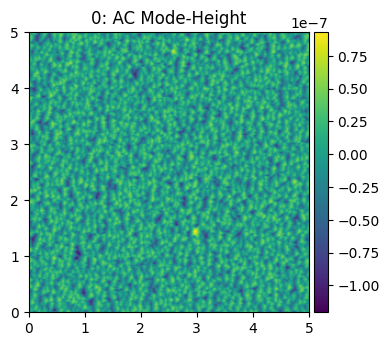

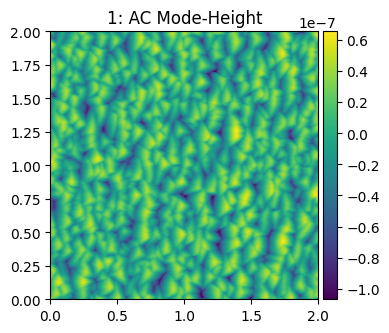

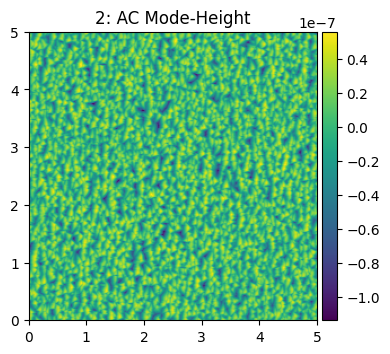

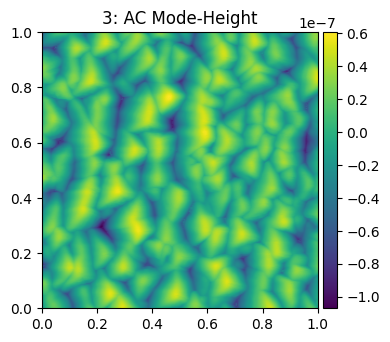

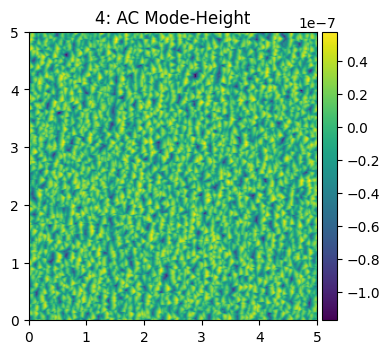

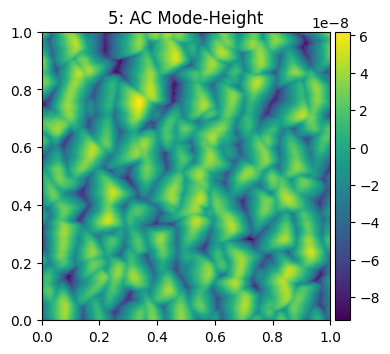

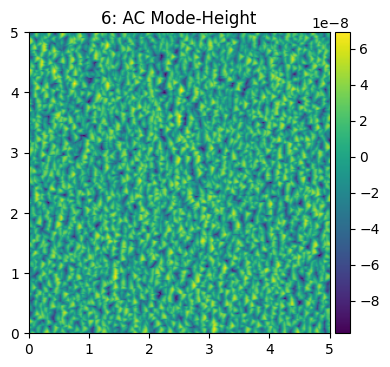

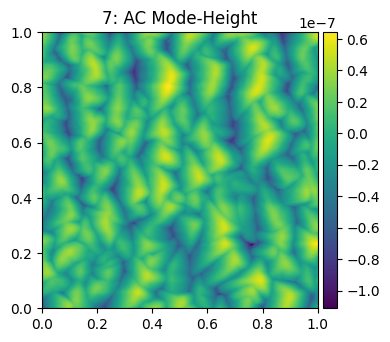

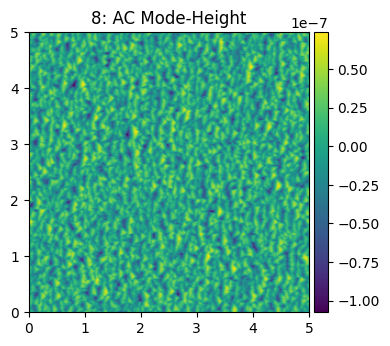

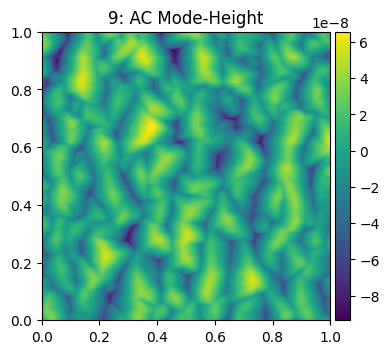

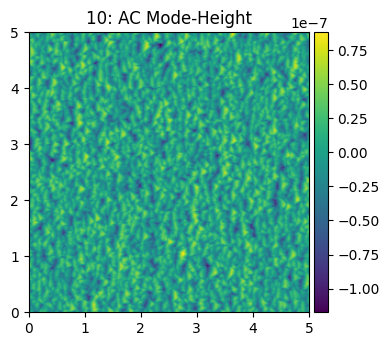

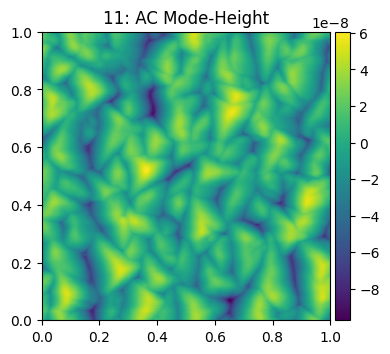

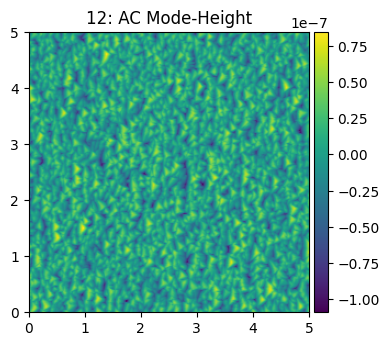

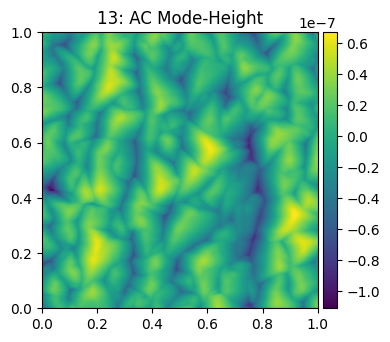

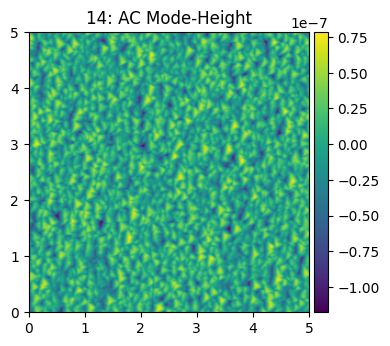

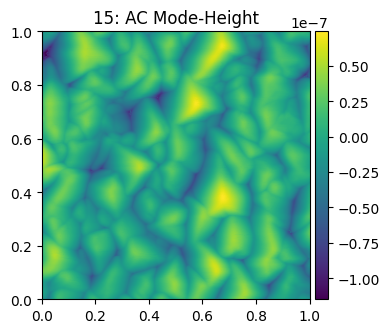

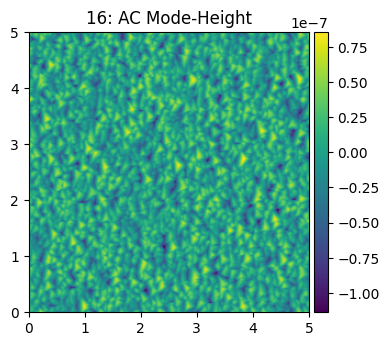

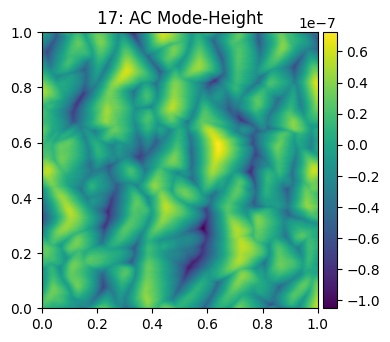

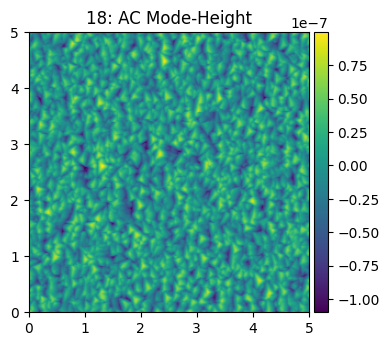

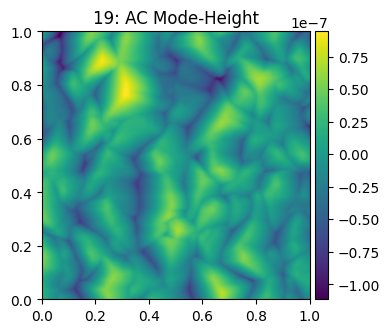

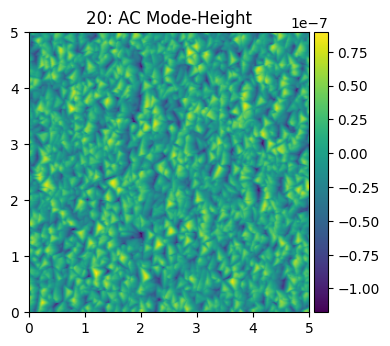

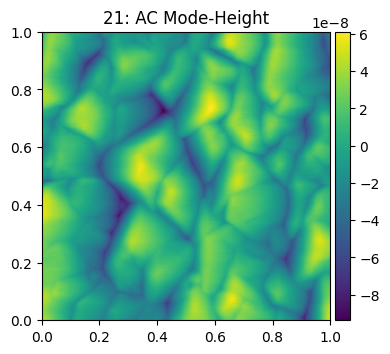

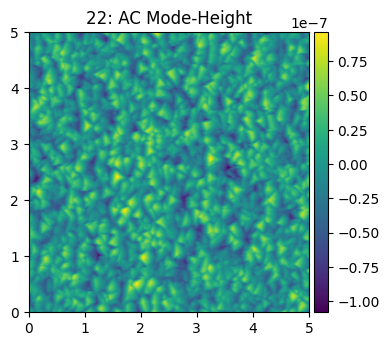

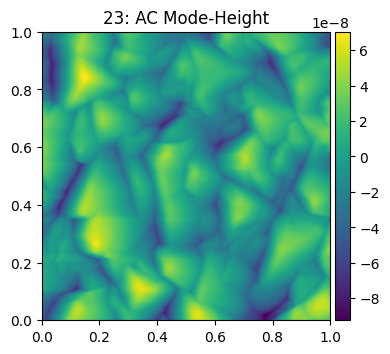

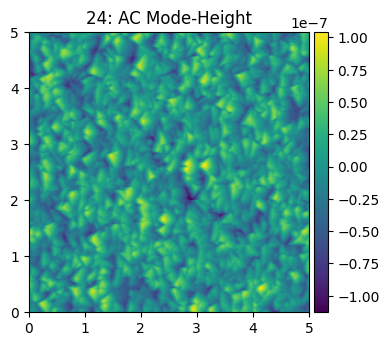

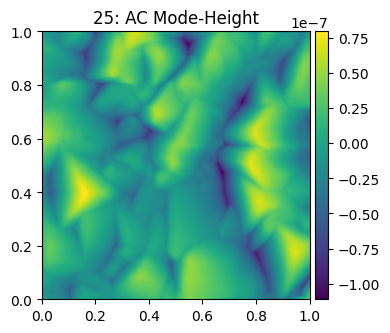

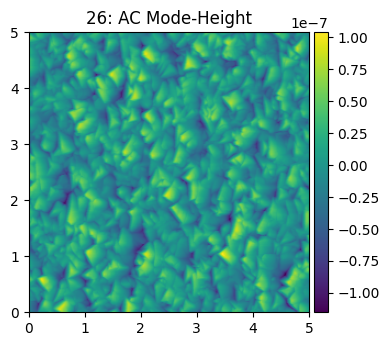

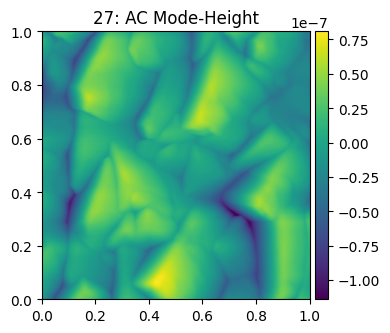

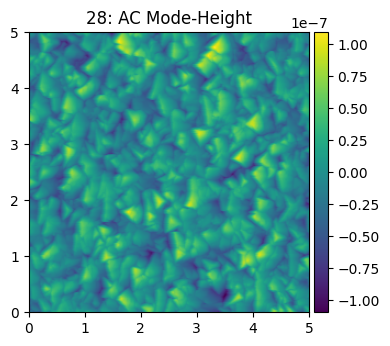

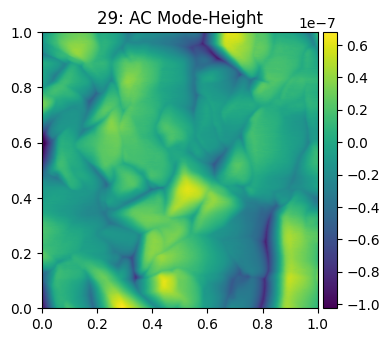

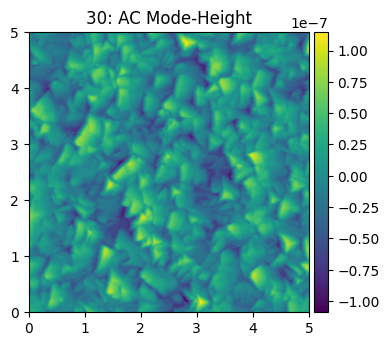

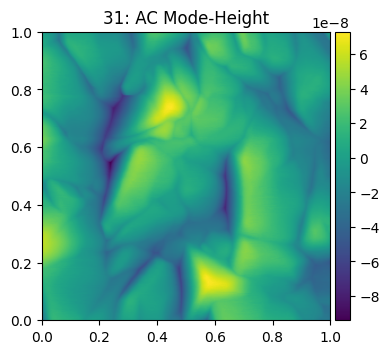

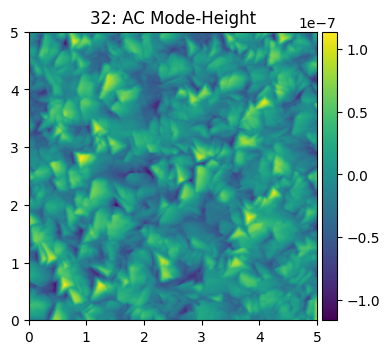

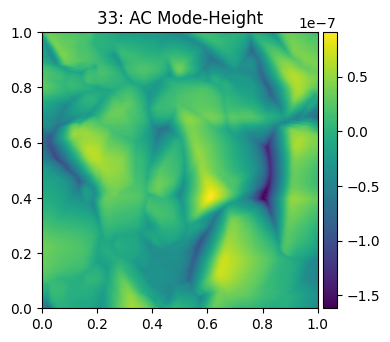

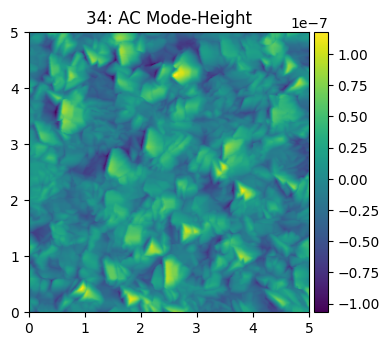

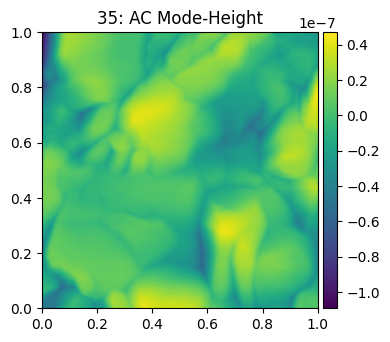

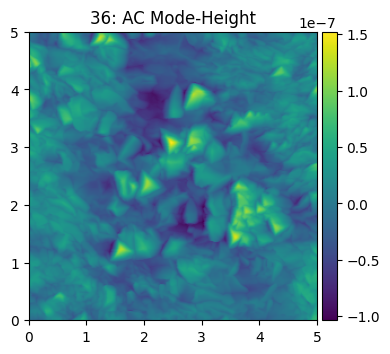

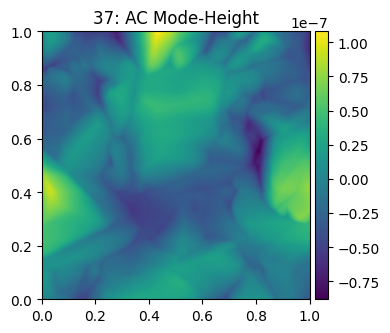

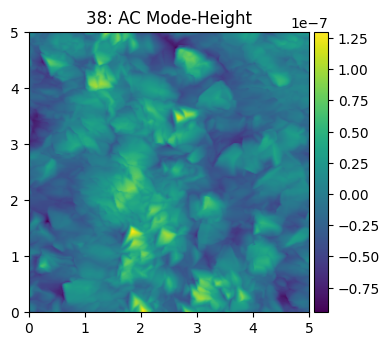

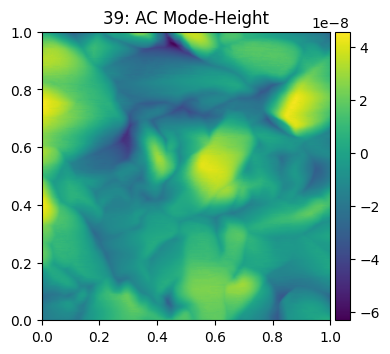

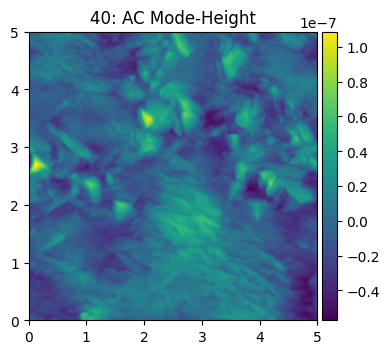

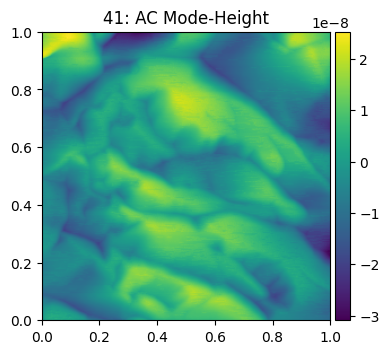

In [9]:
folder = 'WTV_AG/'

fnames, data = display_ibw_folder(folder=folder, key=['Height']);

In [10]:
#crop the part of image scans for analysis. You can utilize any image size, but I got a Resource exhausted error for sizes larger than 128.
image_size = (128, 128)

dataset = np.array([data[i*2+1].data[0] for i in range(len(data)//2)])

crop_dataset = dataset[:,:image_size[0], :image_size[1]]

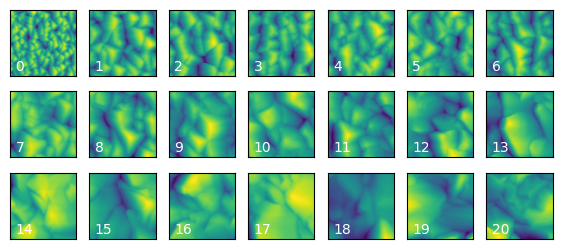

In [11]:
fig, ax = plt.subplots(3,7, figsize=(7,3))

for i,_ in enumerate(ax.flat):
  _.imshow(crop_dataset[i], origin='lower')
  _.set_xticks([])
  _.set_yticks([])
  _.text(10,10, str(i), color='white')

# The orchestrated experiment

In [12]:
#@title LVAE for orchestration
from sklearn.preprocessing import MinMaxScaler

def VAE(dataset,
        batch_size=12,
        latent_dim=2,
        n_epoch=200,
        verbose=False,
        test = None,
        lvae_range = (0,1)):
  x_dataset, y_dataset = dataset
  norm_coef, norm_data = normalize(x_dataset)

  if lvae_range is not None:
    scaler = MinMaxScaler(feature_range=lvae_range)
    y_dataset = scaler.fit_transform(y_dataset[:,np.newaxis]).squeeze()

  in_sh = norm_data.shape[1:]
  if len(in_sh) == 1:
    in_sh = in_sh[0]
  _encoder = Encoder(in_sh, latent_dim=latent_dim).encoder
  _decoder = Decoder(in_sh, latent_dim=latent_dim).decoder
  vae = CustomVAE(_encoder, _decoder, image_size=in_sh)
  vae.compile(optimizer='rmsprop')

  train_dataset = tf.data.Dataset.from_tensor_slices((norm_data, y_dataset))
  train_dataset = train_dataset.batch(batch_size, drop_remainder=True)

  if verbose:
    vae.fit(train_dataset, epochs=n_epoch, verbose=2)
  else:
    vae.fit(train_dataset, epochs=n_epoch, verbose=0)

  if type(test) !=type(None):
    test_norm = (test - norm_coef[0])/norm_coef[1]
    full_mean, full_std, _ = vae.encoder.predict(test_norm)
    return vae, norm_coef, (full_mean, full_std)
  else:
    z_mean, z_std, _ = vae.encoder.predict(norm_data)
    return vae, norm_coef, (z_mean, z_std)

def plot_ld(train, test = None, highlight_latest=True, return_fig=False):
  """
        Plot VAE latent distribution

        Parameters
        ----------
        train: dataset used to train VAE

        test:  full dataset, if available

        highlight_latest: emphasis point, correspondent to the last selected location

        return_fig: return fig object (required if we would like to make video)

        Returns
        -------
        None of plt.fig

  """
  fig, ax = plt.subplots(figsize=(4, 4), dpi=100)
  fig.subplots_adjust(wspace=.3)

  if test is not None:
    ax.scatter(test[:,-2], test[:,-1], color='grey', s=3)
  ax.scatter(train[:,-2], train[:,-1], color='red', s=20, label = 'training')
  if highlight_latest:
    ax.scatter(train[-1,-2], train[-1,-1], color='red', s=60, marker='x', label = 'last_added_point')


  ax.legend()
  for _ in [ax,]:
    _.grid()
    _.set_xlabel('z1')
    _.set_ylabel('z2')
    _.tick_params('both', direction='in')
  plt.show()

  if return_fig:
    return fig

In [13]:
#@title GP functions

from ast import Pass
from gpax import ExactGP
from pyroved.models import iVAE
from typing import Callable, Dict, Optional


#----------- GP BO -------------

class Orchestrated_BO(ExactGP):
  def __init__(self,
               kernel='Matern',
               lengthscale_prior_dist = None,
               noise_prior_dist = None,
               mean_fn = None,
               mean_fn_prior = None):

     super().__init__(1, kernel=kernel,
                         lengthscale_prior_dist=lengthscale_prior_dist,
                         noise_prior_dist = noise_prior_dist,
                         mean_fn = mean_fn,
                         mean_fn_prior = mean_fn_prior)
     self.keys = gpax.utils.get_keys(1)
     self.X_test  = None
     self.X_train = None
     self.y_train = None

  def iteration(self, X_train, y_train, X_test):
    self.X_test  = X_test
    self.X_train = X_train
    self.y_train = y_train

    self.fit(self.keys[0], X_train, y_train)
    self.y_mean, self.y_sampled = self.predict(self.keys[1], X_test, noiseless=True)

  def visualize_res(self, vae_latents=[], **kwargs):
    if self.X_test is None:
      raise ValueError('You must perform iteration first')

    fig = plt.figure(figsize=(6, 4))
    plt.plot(self.y_mean, c='red', label='Prediction')
    plt.fill_between(self.X_test,
                      self.y_mean - self.y_sampled.squeeze().std(0),
                      self.y_mean + self.y_sampled.squeeze().std(0),
                      alpha=0.3, color='red')

    plt.scatter(self.X_train,
                self.y_train,
                c='red',
                label='Experiment',
                alpha=0.6)
    if len(vae_latents) > 0:
        plt.plot(self.X_test,
                 vae_latents, '--',
                 color='black',
                 label='Ground Truth',
                 alpha=0.5)

    plt.legend(loc='lower center', fontsize=8, ncol=3)
    plt.grid(True)
    plt.show()
    return fig


  def acquisition(self, acq_func='EI', maximize=True, visualize=False):
    if acquisition_function == 'EI':
      _acq = gpax.acquisition.EI(self.keys[1], gp_model, self.X_test, maximize=maximize, noiseless=True)
    elif acquisition_function == 'MU':
      _acq = gpax.acquisition.UE(self.keys[1], gp_model, self.X_test, maximize=maximize, noiseless=True)
    elif acquisition_function == 'UCB':
      _acq = gpax.acquisition.UCB(self.keys[1], gp_model, self.X_test, maximize=maximize, noiseless=True)
    else:
      raise ValueError('Unknown acquisition function')

    _acq = np.array(_acq)
    _acq[np.isnan(_acq)==True] = np.random.uniform(low=0.0, high=1.0, size=_acq[np.isnan(_acq)==True].shape)*1e-3
    self.acq = _acq

    maxacq_idx = _acq.argmax()
    maxacq_val = _acq.max()
    self.nextpt = self.X_test[maxacq_idx]

    fig = None
    if visualize:
      fig = self.vis_acq(nextpt=self.nextpt, maxacq_val=maxacq_val)

    return maxacq_idx, maxacq_val, fig



  def vis_acq(self, nextpt=None, maxacq_val=None):
    fig = plt.figure(figsize=(6, 4))
    plt.plot(self.acq, c='r', label="Acquisition function")

    if (nextpt is not None) and (maxacq_val is not None):
      plt.scatter(x=nextpt, y=maxacq_val, color='k', marker = 'X', s=100, label="Next point")

    plt.legend(loc='lower center', fontsize=8)
    plt.title("Acquisition function")
    plt.grid()
    plt.show()
    return fig

  def get_statistics(self,):
    dict_res = {}

    dict_res['X_train']       = np.array(self.X_train).astype(int)
    dict_res['y_train']       = np.array(self.y_train).astype(float)

    dict_res['X_test']        = np.array(self.X_test).astype(int)

    dict_res['noise']         = self.get_samples(1)['noise'].squeeze().mean(0).astype(float)
    dict_res['k_length']      = self.get_samples(1)['k_length'].squeeze().mean(0).astype(float)

    dict_res['y_res_mean']    = np.array(self.y_mean).astype(float)
    dict_res['y_res_uncertainty'] = np.array(tuple(x.squeeze().std(0) for x in self.y_sampled)).astype(float)
    dict_res['next_point'] = np.array(self.nextpt).astype(int)

    return dict_res

In [14]:
#@title auxiliary functions

import h5py

def convert_to_supported_dtype(arr):
    # Check if array has an object dtype
    if arr.dtype == np.dtype('O'):
        # Attempt conversion to a compatible type (if possible)
        try:
            return arr.astype(np.float64)  # Change to a compatible type (e.g., float)
        except ValueError:
            raise ValueError(f"Cannot convert array '{arr}' to a supported dtype.")
    return arr

def save_dict_to_hdf5(file_path, data_dict):
    def save_data(group, data):
        for key, value in data.items():
            if isinstance(value, dict):
                subgroup = group.create_group(key)
                save_data(subgroup, value)
            elif isinstance(value, np.ndarray):
                # Check and convert object dtype arrays if needed
                value = convert_to_supported_dtype(value)
                group.create_dataset(key, data=value)
            else:
                group.create_dataset(key, data=value)

    with h5py.File(file_path, 'w') as f:
        save_data(f, data_dict)

def load_hdf5_to_dict(file_path):
    def load_data(group):
        data = {}
        for key, item in group.items():
            if isinstance(item, h5py.Group):
                data[key] = load_data(item)
            else:
                data[key] = np.array(item)
        return data

    with h5py.File(file_path, 'r') as f:
        data_dict = load_data(f)

    return data_dict

def make_video(path, fig_list, fps=1):
  llist = []
  for f in fig_list:
    f.canvas.draw()
    rgb_array = np.frombuffer(f.canvas.tostring_rgb(), dtype=np.uint8)
    rgb_array = rgb_array.reshape(f.canvas.get_width_height()[::-1] + (3,))
    llist.append(rgb_array)

    imageio.mimwrite(path, llist , fps = fps)


<font color='red'>You can use the following **Ground Truth LVAE** cells to experiment with window size</font>







### Ground Truth LVAE

In [15]:
_, norm_topo = normalize(crop_dataset)

x_topo = np.arange(len(norm_topo))#position in the combi lib for linearization
mod = (norm_topo, x_topo)

In [16]:
vae_topo, _, (z_mod1, z_std1) = VAE(mod, latent_dim=2, batch_size=5,
                          n_epoch=500, lvae_range = (0,1), verbose=True)

Epoch 1/500
4/4 - 9s - loss: 11367.2129 - reconstruction_loss: 11355.5469 - kl_loss: 0.6433 - custom_loss: 11.0234 - 9s/epoch - 2s/step
Epoch 2/500
4/4 - 0s - loss: 11352.6846 - reconstruction_loss: 11348.4961 - kl_loss: 0.7854 - custom_loss: 3.4019 - 123ms/epoch - 31ms/step
Epoch 3/500
4/4 - 0s - loss: 11347.2236 - reconstruction_loss: 11345.0371 - kl_loss: 1.1834 - custom_loss: 1.0016 - 105ms/epoch - 26ms/step
Epoch 4/500
4/4 - 0s - loss: 11351.1504 - reconstruction_loss: 11346.9775 - kl_loss: 1.1923 - custom_loss: 2.9795 - 99ms/epoch - 25ms/step
Epoch 5/500
4/4 - 0s - loss: 11351.2969 - reconstruction_loss: 11348.0361 - kl_loss: 1.0109 - custom_loss: 2.2500 - 90ms/epoch - 22ms/step
Epoch 6/500
4/4 - 0s - loss: 11357.6172 - reconstruction_loss: 11346.1543 - kl_loss: 1.1070 - custom_loss: 10.3556 - 89ms/epoch - 22ms/step
Epoch 7/500
4/4 - 0s - loss: 11348.3174 - reconstruction_loss: 11345.9512 - kl_loss: 1.3089 - custom_loss: 1.0575 - 90ms/epoch - 22ms/step
Epoch 8/500
4/4 - 0s - loss

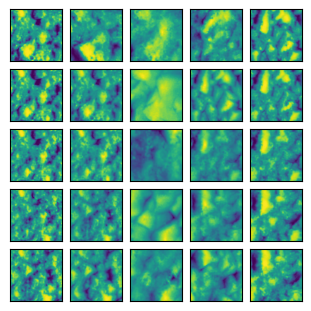

In [17]:
#2D manifold
vae_topo.plot_2Dlatent_space(n=5, figsize=3)

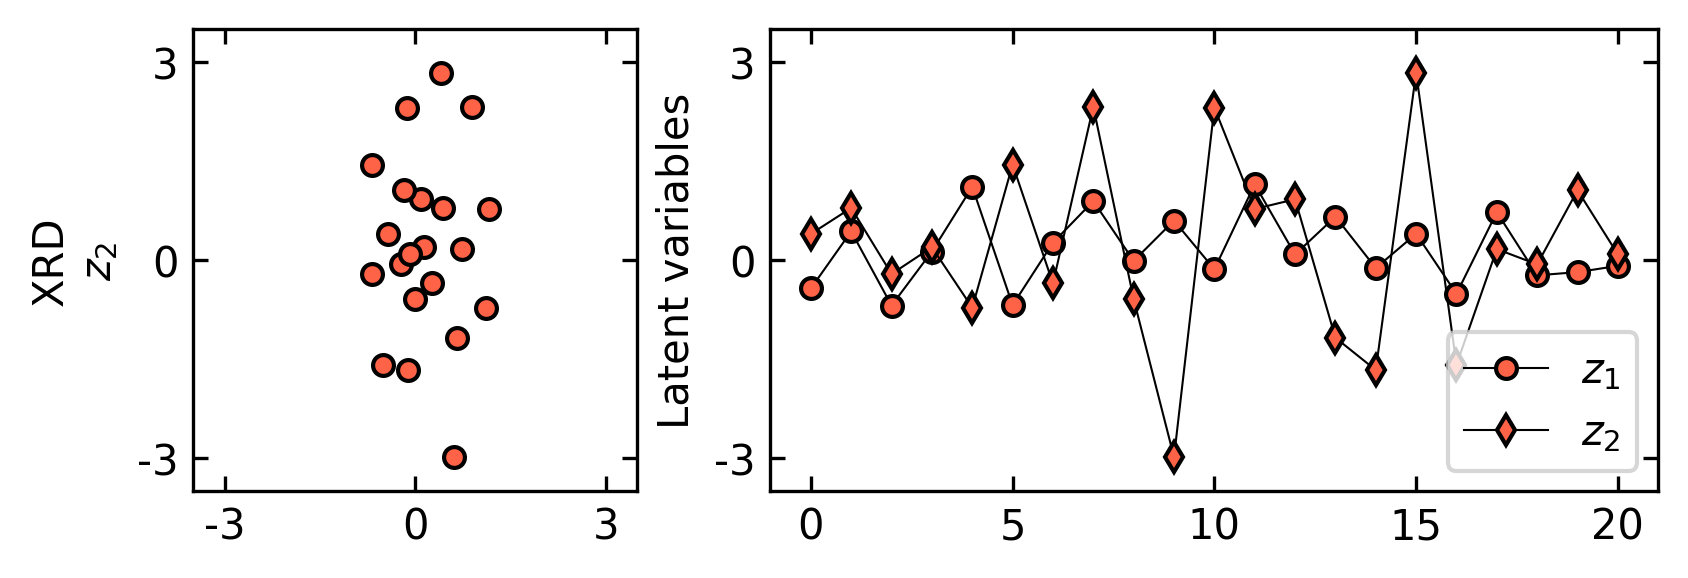

In [18]:
#latent distributions and compositional dependencies of latent variables

import matplotlib.gridspec as gridspec

z_mod = [z_mod1,]
x_mod = [mod[1],]
colors = ['tomato', 'deepskyblue']
modalities = ['XRD', 'Topography']

fig = plt.figure(figsize=(6.3, 2), dpi = 300)
fig.subplots_adjust(wspace=0.2)
gs = gridspec.GridSpec(1, 2, width_ratios=[1,2])

axes = []

for i in range(1):
  ax = fig.add_subplot(gs[i, 0])#, aspect=1.4/7)
  ax.plot(z_mod[i][:,-2], z_mod[i][:,-1], 'o', color='black',
          markersize=5, markerfacecolor=colors[i], lw=0.5)

  ax.set_xlim(-3.5,3.5)
  ax.set_ylim(-3.5,3.5)
  ax.set_xticks([-3, 0, 3])
  ax.set_yticks([-3,0,3])
  ax.set_xticklabels([-3, 0, 3])
  ax.set_yticklabels([-3,0,3])

  ax.set_ylabel('{}\n$z_2$'.format(modalities[i],))

  axes.append(ax)

for i in range(1):
  ax = fig.add_subplot(gs[i, 1])
  ax.plot(x_mod[i], z_mod[i][:,-2], 'o-', color='black',
          markersize=5, markerfacecolor=colors[i], lw=0.5, label='$z_1$')
  ax.plot(x_mod[i], z_mod[i][:,-1], 'd-', color='black',
          markersize=5, markerfacecolor=colors[i], lw=0.5, label='$z_2$')

  ax.set_ylim(-3.5,3.5)
  ax.set_yticks([-3,0,3])
  ax.set_yticklabels([-3,0,3])

  ax.set_ylabel('Latent variables')
  ax.legend(loc = 'lower right')


  axes.append(ax)

for _ in axes:
  _.tick_params('both', right='true', top='true', direction='in')


#fig.savefig('vae_full_gt.jpg', bbox_inches='tight', dpi=300)

### Processing

In [19]:
_, norm_topo = normalize(crop_dataset)

x_topo = np.arange(len(norm_topo))#position in the combi lib for linearization
mod = (norm_topo, x_topo)

Set the priors below

In [20]:
#Priors:  None for default choice or select smth specific


#number of initial measurements (no less than 3)
N_seeds = 3
N_seeds = max(N_seeds, 3)

#VAE
latent_dim = 2
n_epoch = 200

#GP inputs
latent_for_gp = -1 #select vae latent to train gp

#lengthscale_prior_dist
ls = dist.Uniform(0, 30)
#noise prior
noise_prior = dist.HalfNormal(0.3)

mean_fn       = None
mean_fn_prior = None

acquisition_function = 'MU' #or 'UCB', or 'MU', or 'EI'
maximize = True #maximize or minimize acq. func.


#number of exploration steps
N_iteration = 5

# #dataset. I have no ideas why I called it scalarizer.
# scalarizer = None

Execute the following cell in case of sGP.

In [21]:
#@title priors for structured GP
from typing import Dict

import numpyro
import jax.numpy as jnp

def piecewise(x: jnp.ndarray, params: Dict[str, float]) -> jnp.ndarray:
    """Power-law behavior before and after the transition"""
    return jnp.piecewise(
        x, [x < params["t"], x >= params["t"]],
        [lambda x: x**params["beta1"], lambda x: x**params["beta2"]])


def piecewise_priors():
    # Sample model parameters
    t = numpyro.sample("t", numpyro.distributions.Uniform(40, 80))
    beta1 = numpyro.sample("beta1", numpyro.distributions.LogNormal(0, 1))
    beta2 = numpyro.sample("beta2", numpyro.distributions.LogNormal(0, 1))
    # Return sampled parameters as a dictionary
    return {"t": t, "beta1": beta1, "beta2": beta2}


mean_fn       = piecewise
mean_fn_prior = piecewise_priors


-- VAE (seed locations) --
1/1 [==============================] - 0s 84ms/step


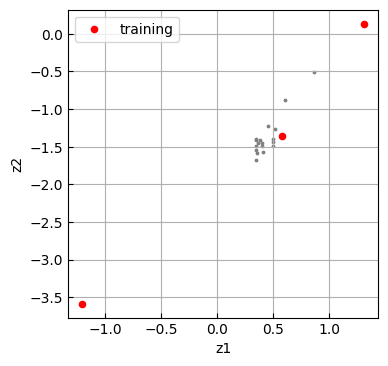


------ Iteration 1 --------


sample: 100%|██████████| 4000/4000 [33:13<00:00,  2.01it/s, 1023 steps of size 6.49e-04. acc. prob=0.96]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta1      0.50      0.04      0.51      0.43      0.55      3.03      2.75
      beta2      2.89      3.58      1.27      0.36      7.99      4.43      1.43
k_length[0]     12.58      5.93     11.01      5.19     24.11      8.53      1.01
    k_scale      5.69      3.69      4.55      1.46     11.37     23.28      1.14
      noise      0.45      0.19      0.42      0.15      0.70     13.73      1.02
          t     70.64      5.20     71.99     62.93     78.29      5.43      1.28



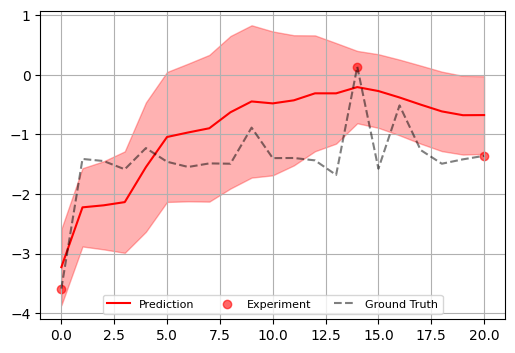

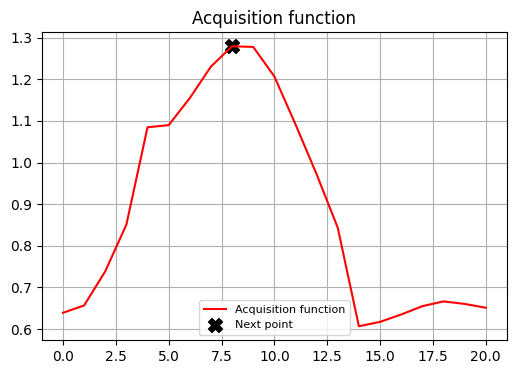


------ Iteration 2 --------

-- VAE iteration 2) --

1/1 [==============================] - 0s 87ms/step


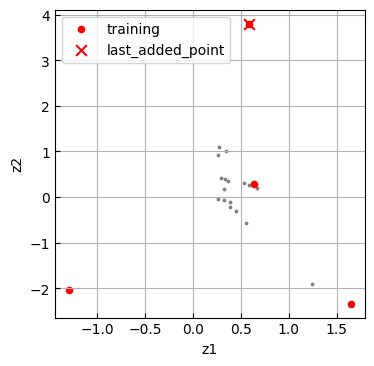

sample: 100%|██████████| 4000/4000 [32:33<00:00,  2.05it/s, 1023 steps of size 2.58e-03. acc. prob=0.72]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta1      0.24      0.11      0.22      0.08      0.42    361.09      1.01
      beta2      1.83      2.59      1.09      0.04      4.01    563.18      1.00
k_length[0]      1.94      1.32      1.83      0.01      3.79    565.39      1.00
    k_scale      4.77      3.14      3.94      1.05      8.45    464.81      1.00
      noise      0.27      0.20      0.24      0.00      0.53    580.39      1.00
          t     60.61     11.55     60.77     44.04     79.31    562.88      1.00



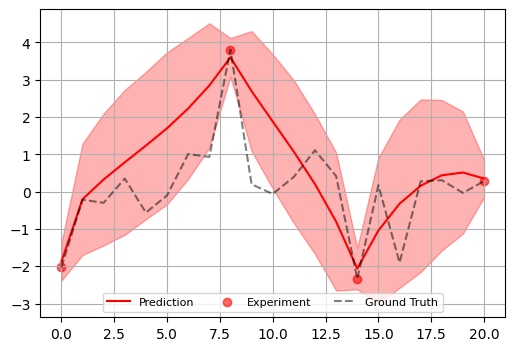

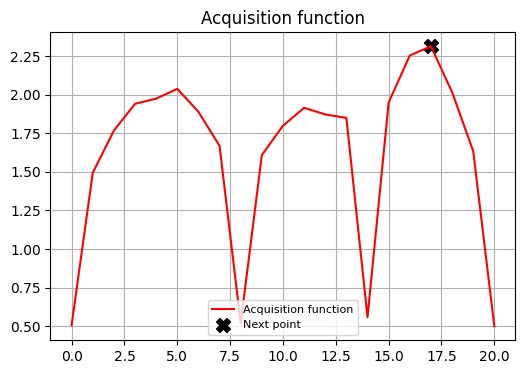


------ Iteration 3 --------

-- VAE iteration 3) --

1/1 [==============================] - 0s 134ms/step


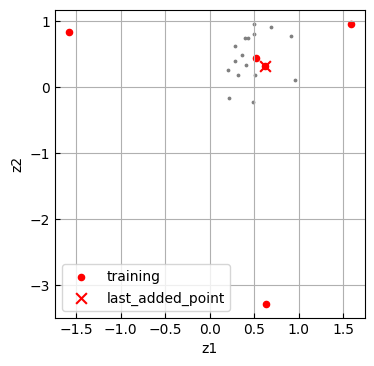

sample: 100%|██████████| 4000/4000 [34:12<00:00,  1.95it/s, 1023 steps of size 1.30e-03. acc. prob=0.82]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta1      0.23      0.09      0.23      0.07      0.34    184.49      1.00
      beta2      2.02      2.75      1.14      0.07      4.43    208.68      1.03
k_length[0]      2.81      1.77      2.74      0.02      4.75    198.60      1.00
    k_scale      3.55      2.48      2.92      0.77      6.18    184.14      1.00
      noise      0.29      0.20      0.27      0.00      0.57    269.07      1.01
          t     60.60     11.49     61.07     44.29     79.87    271.55      1.00



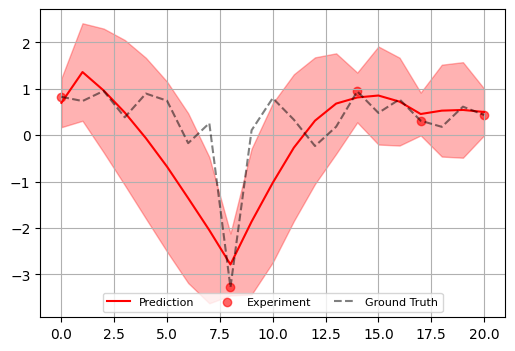

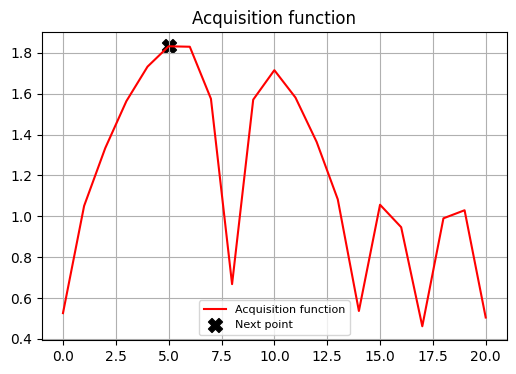


------ Iteration 4 --------

-- VAE iteration 4) --



1/1 [==============================] - 0s 88ms/step


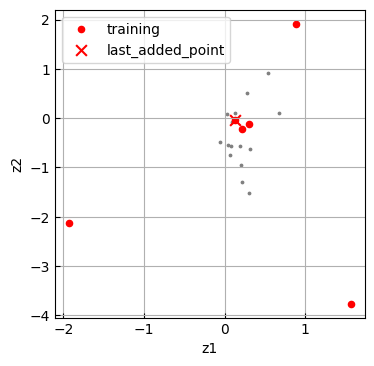

sample: 100%|██████████| 4000/4000 [34:13<00:00,  1.95it/s, 1023 steps of size 3.06e-04. acc. prob=0.98]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta1      0.55      0.02      0.56      0.53      0.57      6.91      1.05
      beta2      3.38      4.54      1.64      0.16      8.38     14.92      1.26
k_length[0]     12.79      9.44     13.60      1.32     26.09      4.57      1.33
    k_scale      5.10      2.36      4.86      1.08      8.09     13.00      1.40
      noise      0.77      0.21      0.78      0.44      1.07      6.94      1.26
          t     71.20      7.50     73.72     59.41     79.41      5.54      1.29



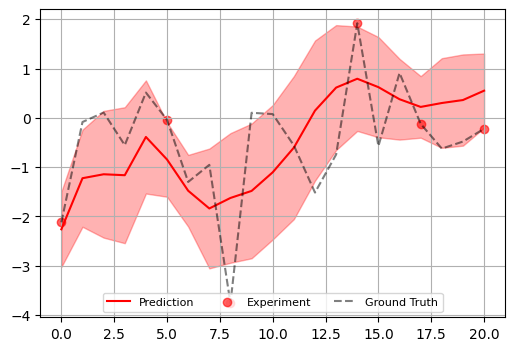

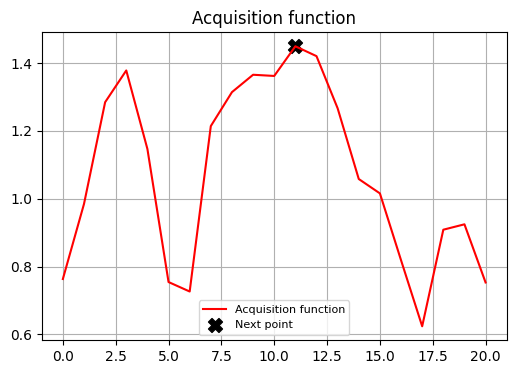


------ Iteration 5 --------

-- VAE iteration 5) --



1/1 [==============================] - 0s 92ms/step


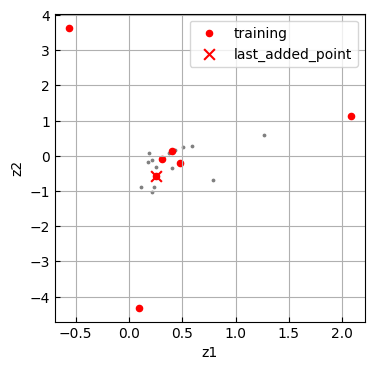

sample: 100%|██████████| 4000/4000 [34:32<00:00,  1.93it/s, 1023 steps of size 5.72e-04. acc. prob=0.90]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta1      0.25      0.11      0.23      0.06      0.42     50.51      1.00
      beta2      1.92      2.21      1.28      0.10      3.96     49.28      1.10
k_length[0]      2.30      1.13      2.37      0.04      3.66     41.30      1.00
    k_scale      5.47      2.65      4.76      2.23      9.61     44.02      1.02
      noise      0.33      0.19      0.31      0.02      0.61     80.25      1.02
          t     61.96     11.79     62.45     44.68     79.91     48.18      1.00



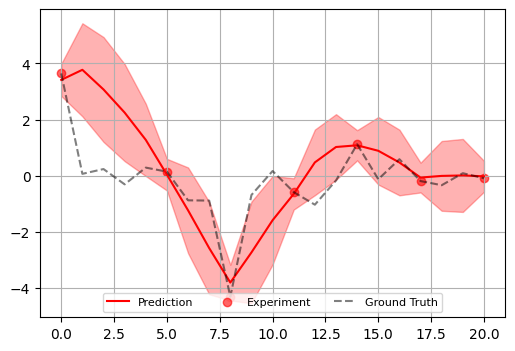

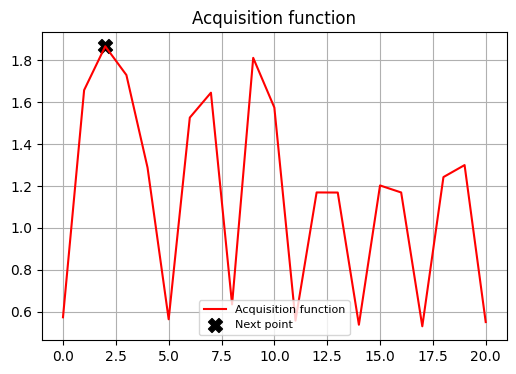

In [22]:
#@title processing
#-------------------------------------------------------
fig_vae = []
fig_acq = []
fig_gp = []

res_stats = {}
#-------------------------------------------------------


X_test =mod[1]#[np.newaxis,:]


#Seed locations
ind_f = np.random.choice(np.arange(1,len(X_test)-1), size=N_seeds-2, replace=False)
ind_f = np.append(ind_f, [0, mod[1].shape[0]-1]).astype(int)


#X_train
X_train = mod[1][ind_f]


#VAE train
VAE_train= [mod[0][ind_f], mod[1][ind_f]] #location of measurements


print(f'\n-- VAE (seed locations) --')

_, _, (z_mean, z_std) = VAE(VAE_train, latent_dim=latent_dim, n_epoch=n_epoch,
                            test=mod[0], batch_size=min(4, len(VAE_train[0])), lvae_range = (0,1))

#z_mean_train is available in the real experiment
z_mean_train = z_mean[ind_f]

fig = plot_ld(train = z_mean_train, test = z_mean, return_fig=True, highlight_latest=False)
fig.suptitle('Iteration 0')
fig_vae.append(fig)

#y train for GP
GP_train = z_mean_train[:, latent_for_gp]

#iterations
for iter in range(N_iteration):

  print(f'\n------ Iteration {iter+1} --------')

  #save current state
  res_stats[f'iter {iter}'] = {'VAE':      np.array(z_mean_train).astype(float),
                               'VAE_full': np.array(z_mean).astype(float),}


#VAE
  if iter > 0:
    print(f'\n-- VAE iteration {iter+1}) --\n')
    ind_f = np.append(ind_f, maxacq_idx)
    X_train = np.append(X_train, X_test[maxacq_idx])

    VAE_train[0] = np.append(VAE_train[0], [mod[0][ind_f[-1]]], axis=0)
    VAE_train[1] = np.append(VAE_train[1], next_idx)

    _, _, (z_mean, z_std) = VAE(VAE_train, latent_dim=latent_dim, n_epoch=n_epoch,
                            test=mod[0], batch_size=min(4, len(VAE_train[0])), lvae_range = (0,1))

    z_mean_train = z_mean[ind_f]

    fig = plot_ld(train = z_mean_train, test = z_mean, return_fig=True)
    fig.suptitle('Iteration {}'.format(iter))
    fig_vae.append(fig)

    #GP_train = np.append(GP_train, 0)
    GP_train = z_mean_train[:,latent_for_gp].squeeze()

#GP BO
  gp_model = Orchestrated_BO(kernel='RBF',
                             lengthscale_prior_dist = ls,
                              noise_prior_dist = noise_prior,
                             mean_fn = mean_fn,
                             mean_fn_prior = mean_fn_prior)

  gp_model.iteration(X_train, np.array(GP_train), X_test)

  fig = gp_model.visualize_res(vae_latents=z_mean[:,latent_for_gp])
  fig_gp.append(fig)

  maxacq_idx, maxacq_val,fig = gp_model.acquisition(acq_func=acquisition_function,
                                                    maximize=True,
                                                    visualize=True)
  fig_acq.append(fig)

  next_idx = X_test[maxacq_idx]

  res_stats[f'iter {iter}'].update(gp_model.get_statistics())

In [23]:
#save results
save_dict_to_hdf5('res.h5', res_stats)

In [24]:
#save figures to the directory

!mkdir figs

for i in range(len(fig_acq)):
  fig_acq[i].savefig('figs/acq_iter_{}.jpeg'.format(i), dpi=300, bbox_inches='tight')
  fig_vae[i].savefig('figs/vae_iter_{}.jpeg'.format(i), dpi=300, bbox_inches='tight')
  fig_gp[i].savefig('figs/gp_iter_{}.jpeg'.format(i), dpi=300, bbox_inches='tight')

### make videofiles

In [25]:
make_video('vae.mp4', fig_vae, fps=1);

/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


In [26]:
Video('vae.mp4', embed=True)

In [27]:
frame_list = []
for i in range(len(fig_gp)):
  fig_gp[i].set_dpi(100)
  fig_gp[i].suptitle('Iteration {}'.format(i))
  fig_gp[i].canvas.draw()
  rgb_gp = np.frombuffer(fig_gp[i].canvas.tostring_rgb(), dtype=np.uint8)
  rgb_gp = rgb_gp.reshape(fig_gp[i].canvas.get_width_height()[::-1] + (3,))

  fig_acq[i].set_dpi(100)
  fig_acq[i].canvas.draw()
  rgb_acq = np.frombuffer(fig_acq[i].canvas.tostring_rgb(), dtype=np.uint8)
  rgb_acq = rgb_acq.reshape(fig_acq[i].canvas.get_width_height()[::-1] + (3,))

  frame_list.append(np.concatenate([rgb_gp, rgb_acq], axis=1))

imageio.mimwrite('gp.mp4', frame_list , fps = 1)

In [28]:
Video('gp.mp4', embed=True)